#  **Data Visualizations**

## **Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
%matplotlib inline
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder
#Scipy
from scipy import stats
from scipy.stats import norm

#Sklearn Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, set_config
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.decomposition import PCA


# Warnings 
import warnings 
warnings.filterwarnings("ignore")

# Configuring diagrams
set_config(display = 'diagram')

In [2]:
# Load NYC Restaraunt Data 
rd =pd.read_csv('rd')

In [3]:
# Check to see if Data Loaded Properly
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242682 entries, 0 to 242681
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  242682 non-null  int64  
 1   DBA                    241853 non-null  object 
 2   BORO                   242682 non-null  object 
 3   BUILDING               242284 non-null  object 
 4   STREET                 242668 non-null  object 
 5   ZIPCODE                239855 non-null  float64
 6   CUISINE DESCRIPTION    239995 non-null  object 
 7   INSPECTION DATE        242682 non-null  object 
 8   ACTION                 239995 non-null  object 
 9   VIOLATION CODE         238662 non-null  object 
 10  VIOLATION DESCRIPTION  238662 non-null  object 
 11  CRITICAL FLAG          242682 non-null  object 
 12  SCORE                  230796 non-null  float64
 13  GRADE                  116932 non-null  object 
 14  GRADE DATE             107898 non-nu

# **Data Cleaning**

In [4]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # check if the input is a string 
    if isinstance(name, str):
        # Remove store numbers using regular expression 
        cleaned_name = re.sub(r'#\d+','', name)
        # Remove all numeric characters 
        cleaned_name = re.sub(r'#\d+', '', cleaned_name)
        #Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
        return cleaned_name
    else:
        return name #Return the input unchanged for non-string values
# Apply the clean_restaurant_name function to the 'DBA' column
rd['Cleaned Restaurant Name'] = rd['DBA'].apply(clean_restaurant_name)
# Drop the origianl 'DBA' column if you want 
#rd.drop(columns=['DBA'], inplace = True)

In [5]:
# checking missing data in data 
def check_missing_data(rd):
    total = rd.isnull().sum().sort_values(ascending=False)
    percent = (rd.isnull().sum() / rd.isnull().count() * 100).sort_values(ascending=False)
    percent = percent.round(2).astype(str) + '%'  # Add the percentage sign
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(rd)
missing_data_result.head()

,Total,Percent
GRADE DATE,134784,55.54%
GRADE,125750,51.82%
SCORE,11886,4.9%
VIOLATION DESCRIPTION,4020,1.66%
VIOLATION CODE,4020,1.66%


In [6]:
# Checking for duplicates 
rd.duplicated().sum()

6

In [7]:
rd['SCORE'].describe()

count    230796.000000
mean         23.670922
std          17.977934
min           0.000000
25%          12.000000
50%          20.000000
75%          32.000000
max         168.000000
Name: SCORE, dtype: float64

In [8]:
rd['CAMIS'].value_counts()

CAMIS
40398688    65
40365904    65
50105561    64
50111296    63
50089474    62
            ..
41241757     1
50150212     1
50130768     1
50127680     1
50153649     1
Name: count, Length: 29115, dtype: int64

In [9]:
rd['INSPECTION TYPE'].value_counts()

INSPECTION TYPE
Cycle Inspection / Initial Inspection                          134022
Cycle Inspection / Re-inspection                                42044
Pre-permit (Operational) / Initial Inspection                   35697
Pre-permit (Operational) / Re-inspection                        10103
Administrative Miscellaneous / Initial Inspection                6303
Pre-permit (Non-operational) / Initial Inspection                3151
Pre-permit (Operational) / Compliance Inspection                 1694
Cycle Inspection / Reopening Inspection                          1456
Administrative Miscellaneous / Re-inspection                     1148
Cycle Inspection / Compliance Inspection                          974
Pre-permit (Operational) / Reopening Inspection                   754
Smoke-Free Air Act / Initial Inspection                           576
Trans Fat / Initial Inspection                                    422
Inter-Agency Task Force / Initial Inspection                      387
Calo

In [10]:
# Looking at different Restaurant Types, Potential to filter out specific types for geospacial analysis
all_unique_values = rd['CUISINE DESCRIPTION'].unique()
print(all_unique_values)

[nan 'Ethiopian' 'Bakery Products/Desserts' 'Frozen Desserts' 'Thai'
 'Salads' 'Chinese' 'Donuts' 'Mexican' 'American' 'Japanese'
 'Asian/Asian Fusion' 'Mediterranean' 'Coffee/Tea' 'Korean' 'Italian'
 'Latin American' 'Spanish' 'Chicken' 'Bagels/Pretzels' 'Creole/Cajun'
 'Egyptian' 'Pizza' 'Sandwiches' 'Caribbean' 'Jewish/Kosher' 'Peruvian'
 'Juice, Smoothies, Fruit Salads' 'Eastern European' 'Chinese/Japanese'
 'Greek' 'Californian' 'Sandwiches/Salads/Mixed Buffet' 'Seafood'
 'Bangladeshi' 'African' 'French' 'Middle Eastern' 'German' 'Hamburgers'
 'Turkish' 'Indian' 'Tex-Mex' 'Continental' 'Fusion' 'Russian'
 'Australian' 'Creole' 'Other' 'Filipino' 'Vegetarian' 'Pancakes/Waffles'
 'Southwestern' 'Soul Food' 'Bottled Beverages' 'Irish' 'Barbecue'
 'Southeast Asian' 'Brazilian' 'Steakhouse' 'Indonesian' 'Hawaiian'
 'New French' 'Pakistani' 'Vegan' 'Hotdogs' 'Afghan' 'Tapas' 'English'
 'Not Listed/Not Applicable' 'Scandinavian' 'Soups/Salads/Sandwiches'
 'Polish' 'Hotdogs/Pretzels' 'Fru

## **Grade Date by Year**

In [11]:
# Convert the 'GRADE DATE' column to datetime type
rd['GRADE DATE'] = pd.to_datetime(rd['GRADE DATE'])

# Filter rows for the year 2016
desired_year = 2016 
filtered_df = rd[rd['GRADE DATE'].dt.year == desired_year]

# Display the rows for the specified year
print (filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 102 to 242649
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    236 non-null    int64         
 1   DBA                      236 non-null    object        
 2   BORO                     236 non-null    object        
 3   BUILDING                 226 non-null    object        
 4   STREET                   236 non-null    object        
 5   ZIPCODE                  176 non-null    float64       
 6   CUISINE DESCRIPTION      236 non-null    object        
 7   INSPECTION DATE          236 non-null    object        
 8   ACTION                   236 non-null    object        
 9   VIOLATION CODE           199 non-null    object        
 10  VIOLATION DESCRIPTION    199 non-null    object        
 11  CRITICAL FLAG            236 non-null    object        
 12  SCORE                    236 non-nul

In [12]:
# Convert the 'GRADE DATE' column to datetime type
rd['INSPECTION DATE'] = pd.to_datetime(rd['INSPECTION DATE'])

# Filter rows for the year 2016
desired_year = 2023 
filtered_df = rd[rd['INSPECTION DATE'].dt.year == desired_year]

# Display the rows for the specified year
print (filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 80410 entries, 4 to 242680
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    80410 non-null  int64         
 1   DBA                      80410 non-null  object        
 2   BORO                     80410 non-null  object        
 3   BUILDING                 80322 non-null  object        
 4   STREET                   80410 non-null  object        
 5   ZIPCODE                  79620 non-null  float64       
 6   CUISINE DESCRIPTION      80410 non-null  object        
 7   INSPECTION DATE          80410 non-null  datetime64[ns]
 8   ACTION                   80410 non-null  object        
 9   VIOLATION CODE           79970 non-null  object        
 10  VIOLATION DESCRIPTION    79970 non-null  object        
 11  CRITICAL FLAG            80410 non-null  object        
 12  SCORE                    76650 non-n

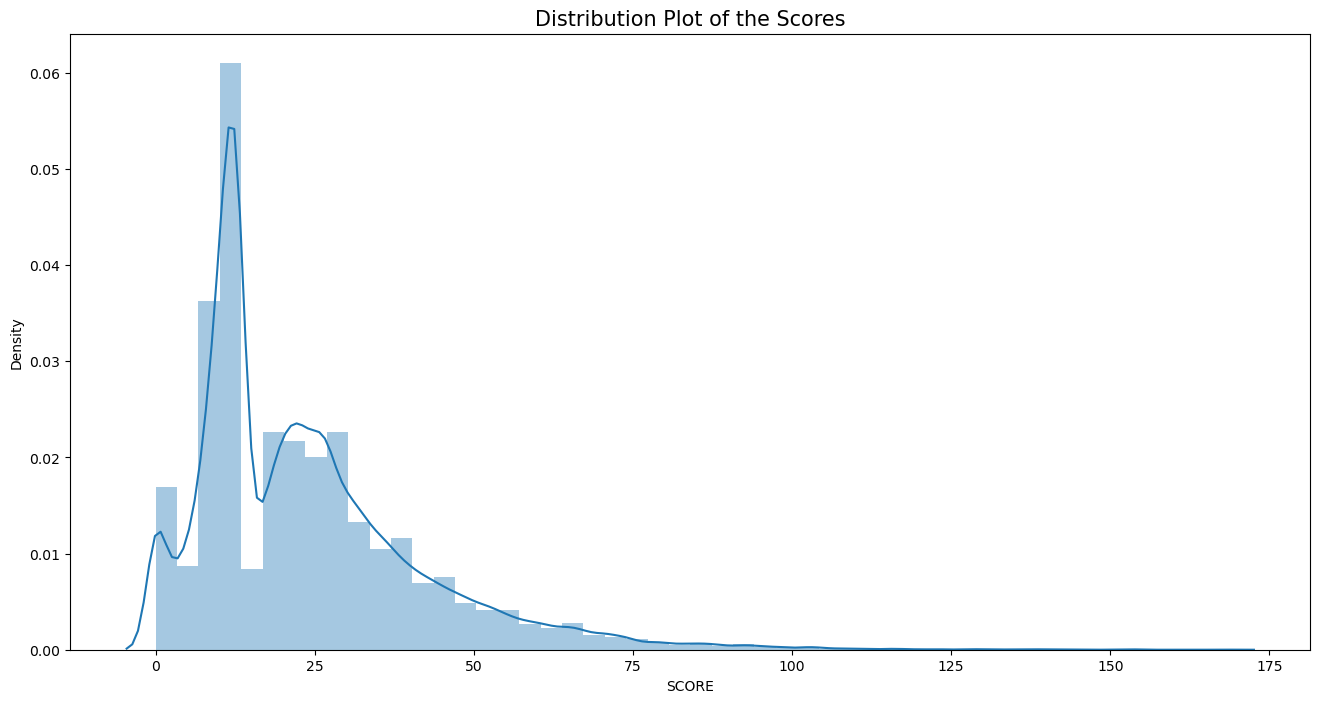

In [13]:
# Have a look at a distribution plot of the Score
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
sns.distplot(rd.SCORE.dropna())
plt.title("Distribution Plot of the Scores", fontsize=15);

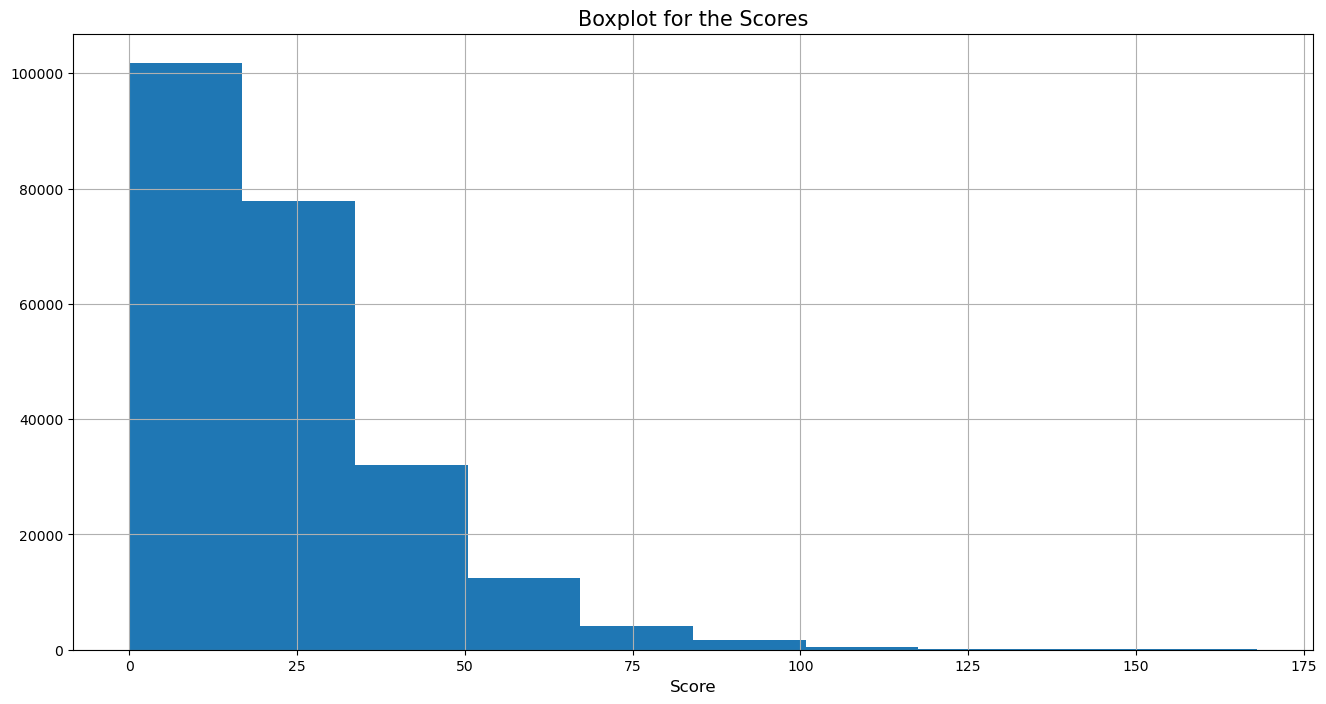

In [14]:
# Plot a histogram
rd.SCORE.hist(figsize=(16,8))
plt.title("Boxplot for the Scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

In [15]:
# Filter rows where 'BORO' is 0
f_df = rd[rd['BORO'] != '0']

# Display the filtered DataFrame
print(f_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 242662 entries, 0 to 242681
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CAMIS                    242662 non-null  int64         
 1   DBA                      241845 non-null  object        
 2   BORO                     242662 non-null  object        
 3   BUILDING                 242278 non-null  object        
 4   STREET                   242662 non-null  object        
 5   ZIPCODE                  239849 non-null  float64       
 6   CUISINE DESCRIPTION      239995 non-null  object        
 7   INSPECTION DATE          242662 non-null  datetime64[ns]
 8   ACTION                   239995 non-null  object        
 9   VIOLATION CODE           238662 non-null  object        
 10  VIOLATION DESCRIPTION    238662 non-null  object        
 11  CRITICAL FLAG            242662 non-null  object        
 12  SCORE                

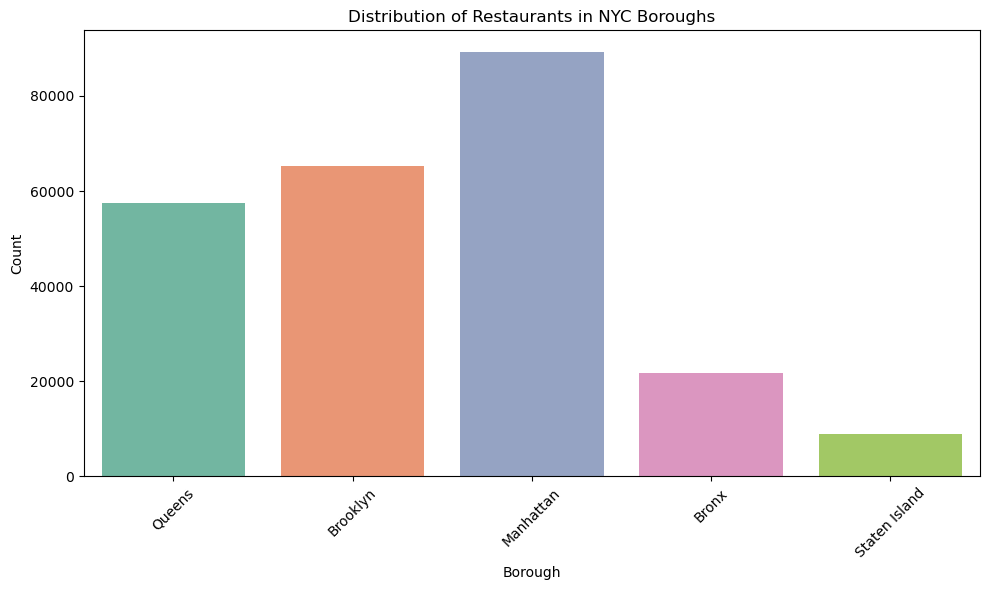

In [16]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(10, 6))
sns.countplot(data=f_df, x='BORO', palette='Set2') 
plt.title('Distribution of Restaurants in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

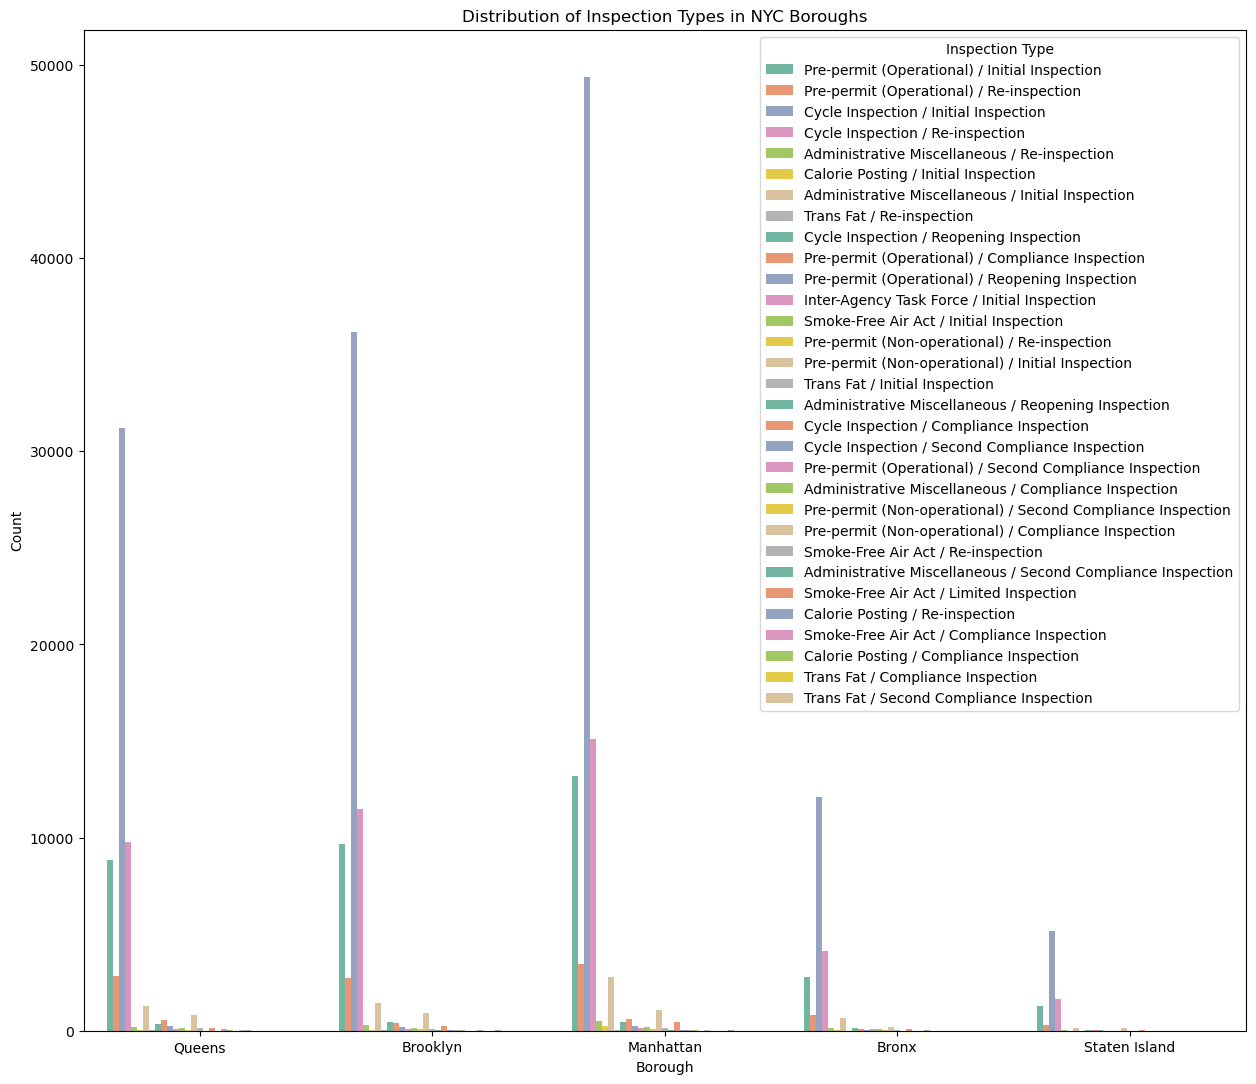

In [17]:
# Create a stacked bar chart using Seaborn
plt.figure(figsize=(15,13))
sns.countplot(x='BORO', hue='INSPECTION TYPE', data=f_df, palette='Set2')
plt.title('Distribution of Inspection Types in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
# Show the plot
plt.legend(title='Inspection Type', bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

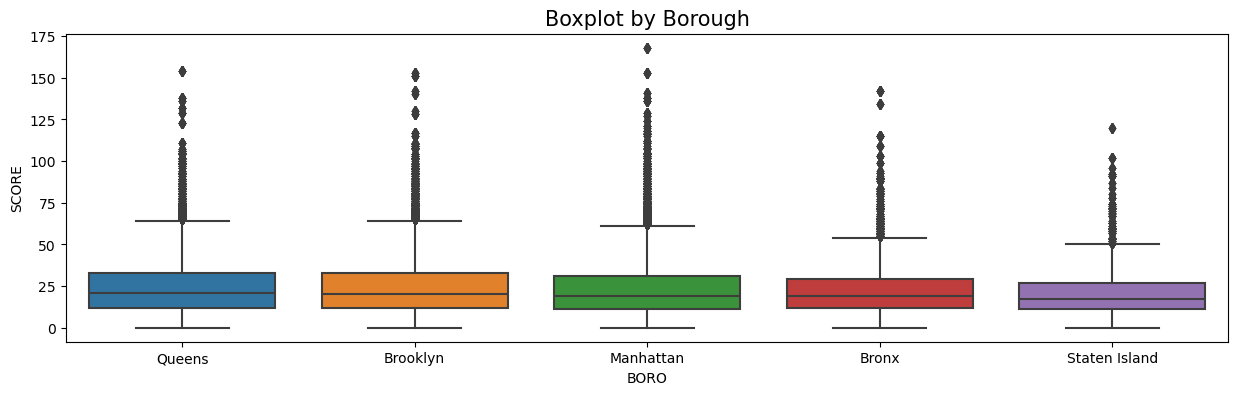

In [18]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='BORO', y='SCORE', data=f_df)
plt.title('Boxplot by Borough', fontsize=15)

# Show the plot
plt.show()

## **Grade**

In [19]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rd.GRADE, rd.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6960,21539,30983,18612,3550,81644
B,1437,3538,4595,3406,515,13491
C,683,2258,2859,2213,182,8195
N,684,2193,3559,2351,267,9054
P,70,205,210,173,20,678
Z,411,1014,1320,1041,84,3870
All,10245,30747,43526,27796,4618,116932


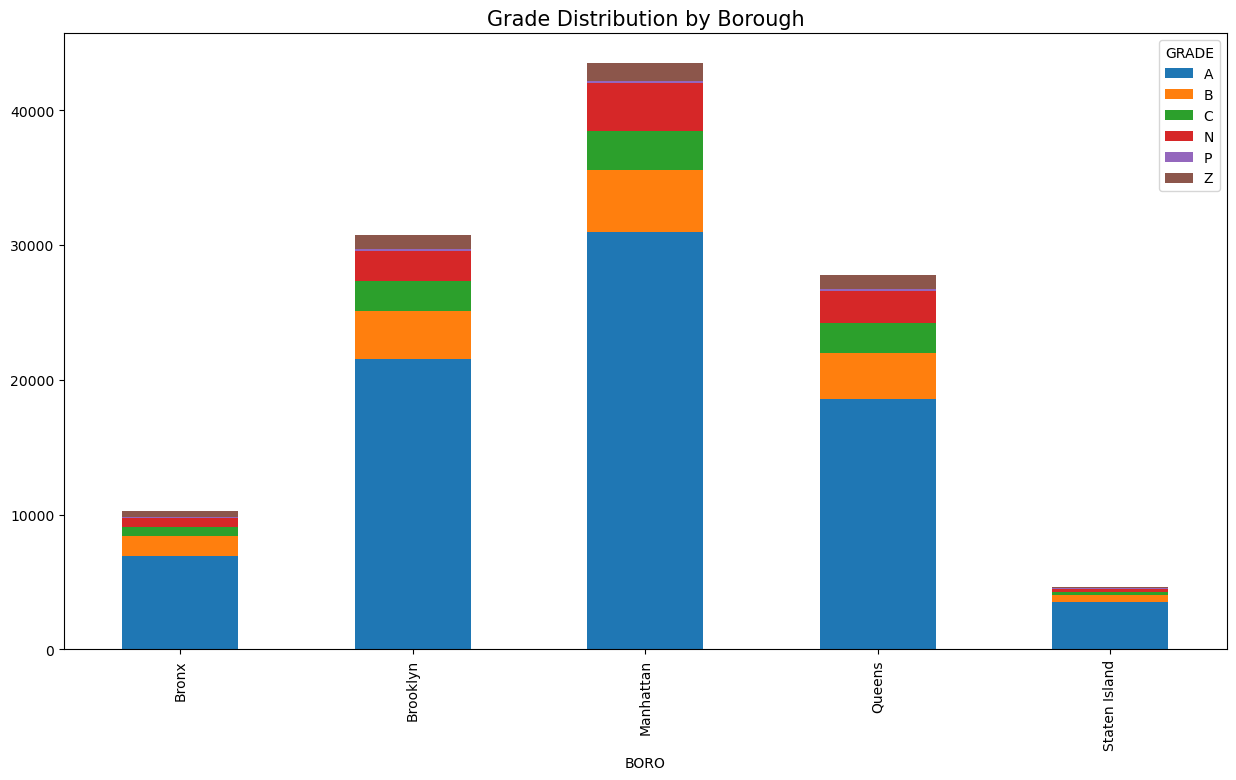

In [20]:
# Plot of grade by borough
pd.crosstab(rd.BORO, rd.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

In [21]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rd.GRADE, rd.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6960,21539,30983,18612,3550,81644
B,1437,3538,4595,3406,515,13491
C,683,2258,2859,2213,182,8195
N,684,2193,3559,2351,267,9054
P,70,205,210,173,20,678
Z,411,1014,1320,1041,84,3870
All,10245,30747,43526,27796,4618,116932


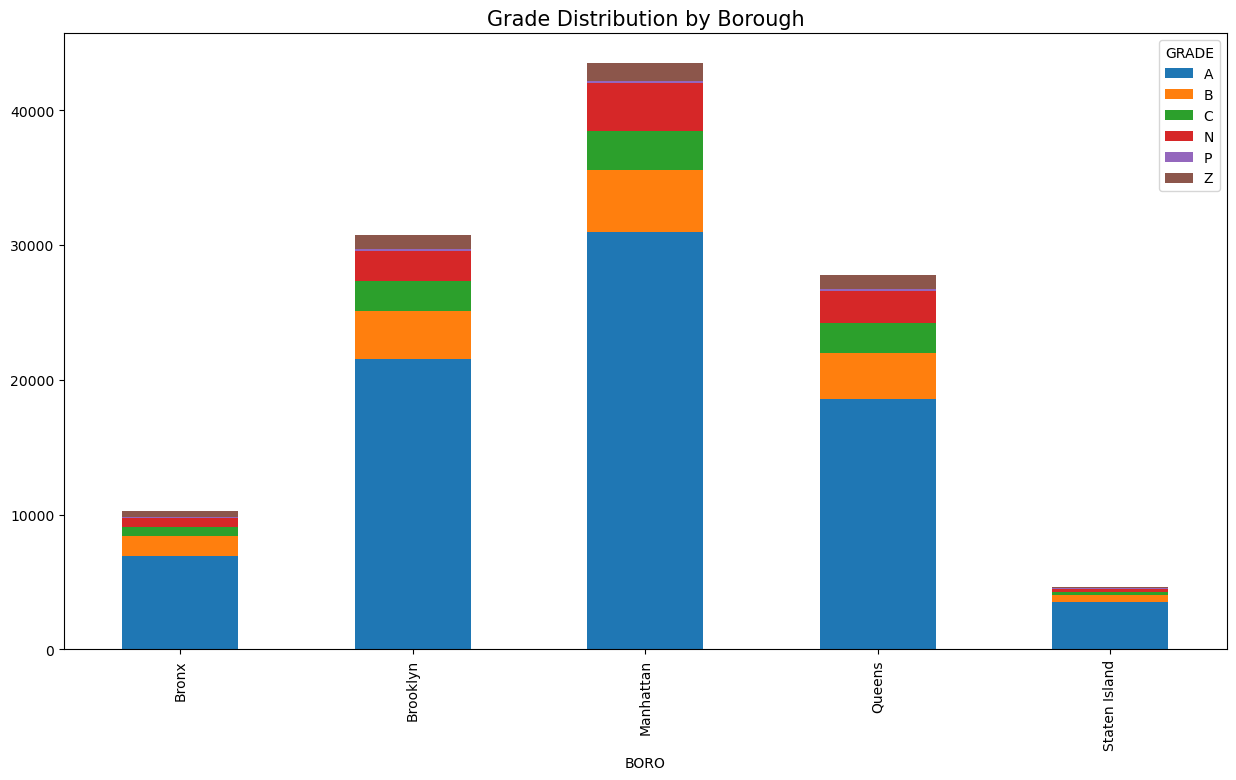

In [22]:
# Plot of grade by borough
pd.crosstab(rd.BORO, rd.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

In [23]:
# Test if the grades are independent of the borough
boro_grade.columns = ["BRONX","BROOKLYN","MANHATTAN", "QUEENS", "STATEN ISLAND" ,"All"]

boro_grade.index = ["A","B","C","Not Yet Graded","P", "Z", "All"]

observed = boro_grade.iloc[0:6,0:5]   # Get table without totals for later use

expected =  np.outer(boro_grade["All"][0:6],
                     boro_grade.loc["All"][0:5]) / 1000

expected = pd.DataFrame(expected)

chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print("Chi Squared Stat")
print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 20)   # (5-1) * (6-1)

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=20)
print("P value")
print(p_value)

stats.chi2_contingency(observed= observed)

Chi Squared Stat
0.0
Critical value
31.410432844230918
P value
1.0


Chi2ContingencyResult(statistic=473.0651050130976, pvalue=1.2509658573684775e-87, dof=20, expected_freq=array([[7.15324103e+03, 2.14681017e+04, 3.03906266e+04, 1.94076611e+04,
        3.22436965e+03],
       [1.18201429e+03, 3.54742737e+03, 5.02180127e+03, 3.20695649e+03,
        5.32800585e+02],
       [7.18005123e+02, 2.15485637e+03, 3.05045300e+03, 1.94804006e+03,
        3.23645452e+02],
       [7.93266428e+02, 2.38072844e+03, 3.37020152e+03, 2.15223364e+03,
        3.57569972e+02],
       [5.94029864e+01, 1.78278538e+02, 2.52374269e+02, 1.61167927e+02,
        2.67762802e+01],
       [3.39070143e+02, 1.01760758e+03, 1.44054339e+03, 9.19940820e+02,
        1.52838060e+02]]))

## **Distribution of Grades**

Text(0.5, 1.0, 'Boxplot by Grade')

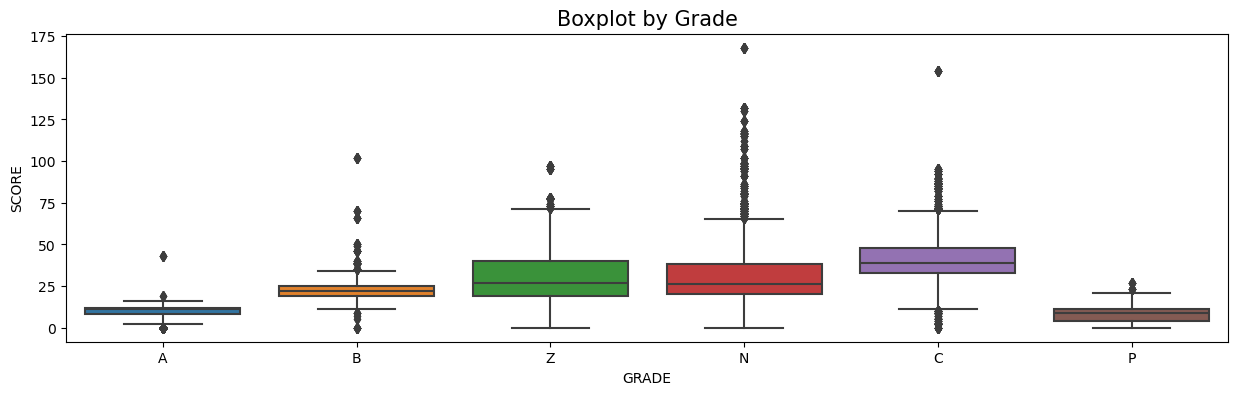

In [24]:
# Lets look at scores by grades with a Boxplot
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='GRADE', y='SCORE', data=rd)
plt.title('Boxplot by Grade', fontsize = 15)

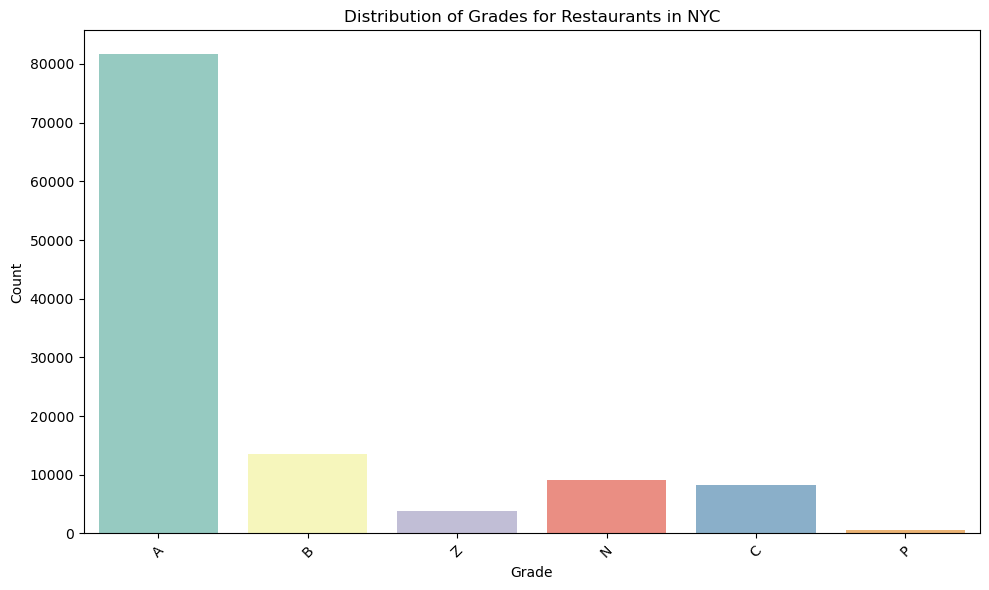

In [25]:
# Visualizing Distribution of Grades for Restaurants in NYC
plt.figure(figsize=(10, 6))
sns.countplot(data=rd, x='GRADE', palette='Set3')  
plt.title('Distribution of Grades for Restaurants in NYC')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

## **Distribution of Cuisine Types**

In [26]:
# Filteriung out the irrelevant Cuisine Types for Visalization
min_cuisine_count = 1000
cuisine_counts = rd['CUISINE DESCRIPTION'].value_counts()
filtered_cuisines = cuisine_counts[cuisine_counts >= min_cuisine_count].index
fdf = rd[rd['CUISINE DESCRIPTION'].isin(filtered_cuisines)]

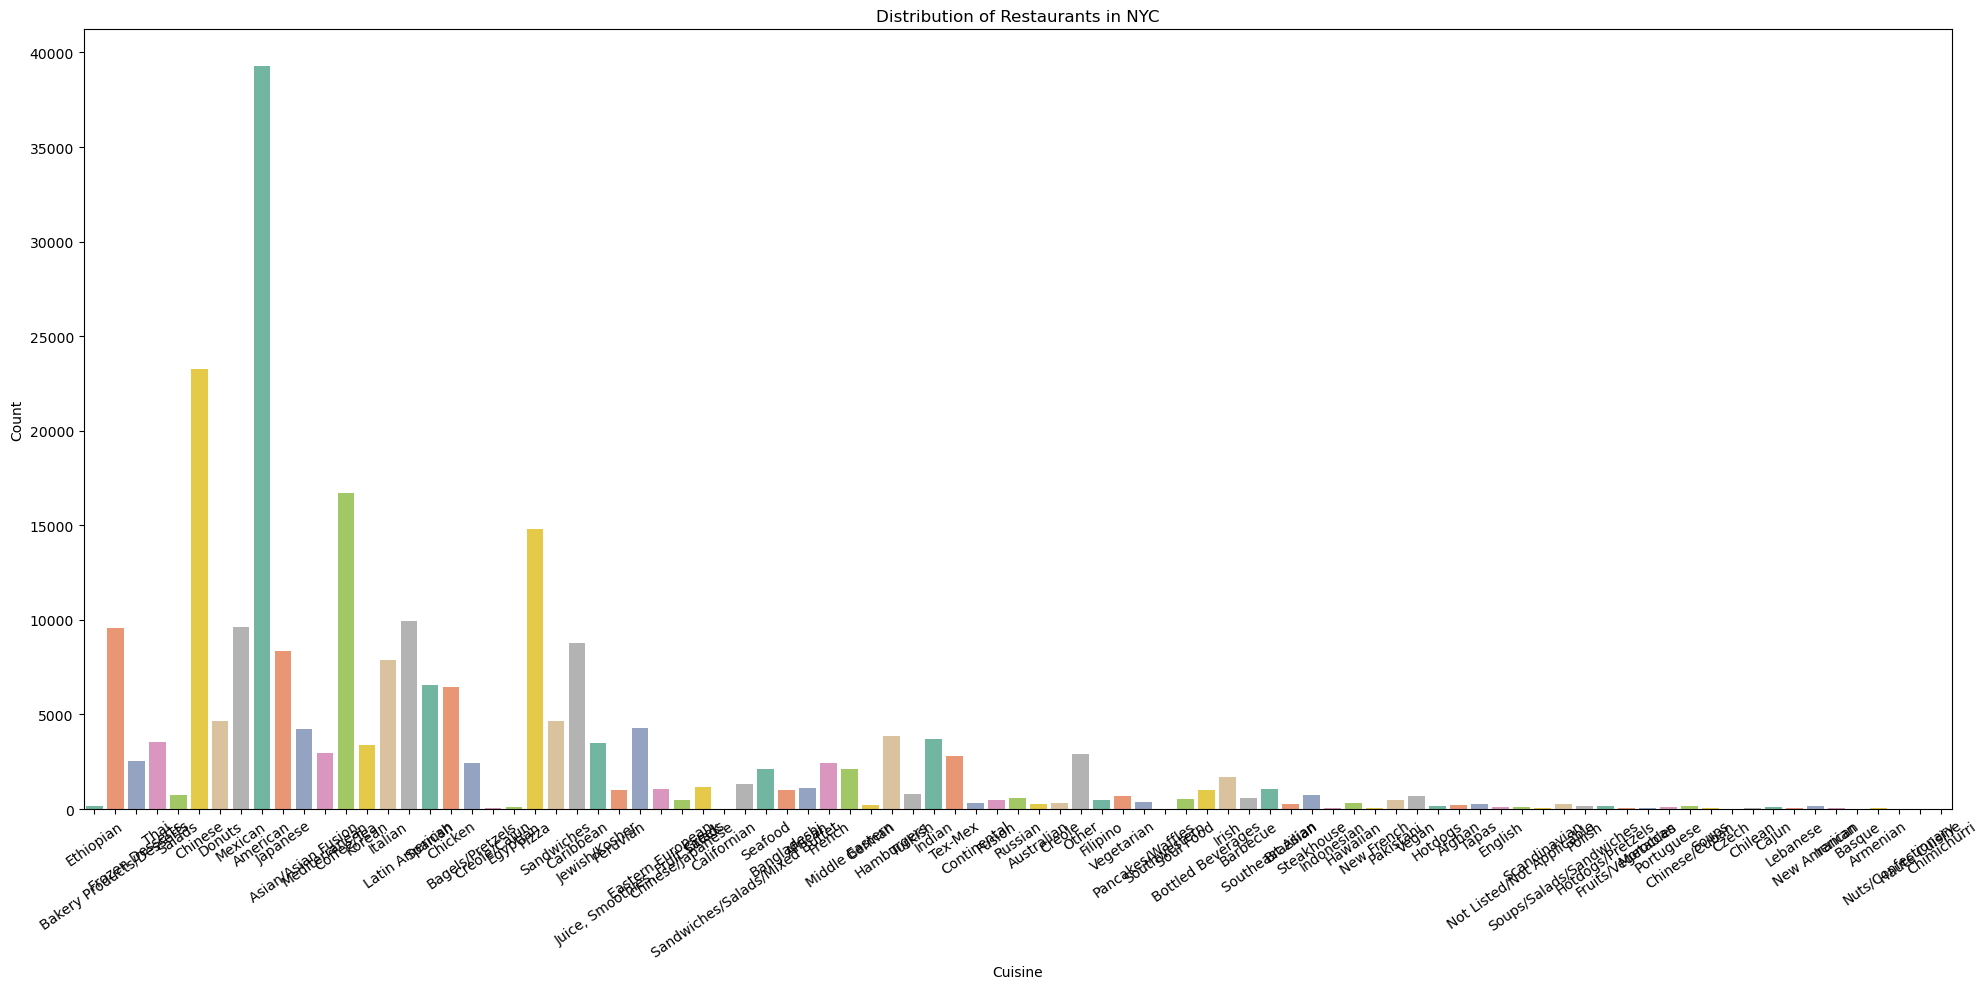

In [27]:
# Visualization of most popular cuisines
plt.figure(figsize=(20,10))
sns.countplot(data=f_df, x='CUISINE DESCRIPTION', palette='Set2') 
plt.title('Distribution of Restaurants in NYC')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=35) 

plt.tight_layout()
plt.show()

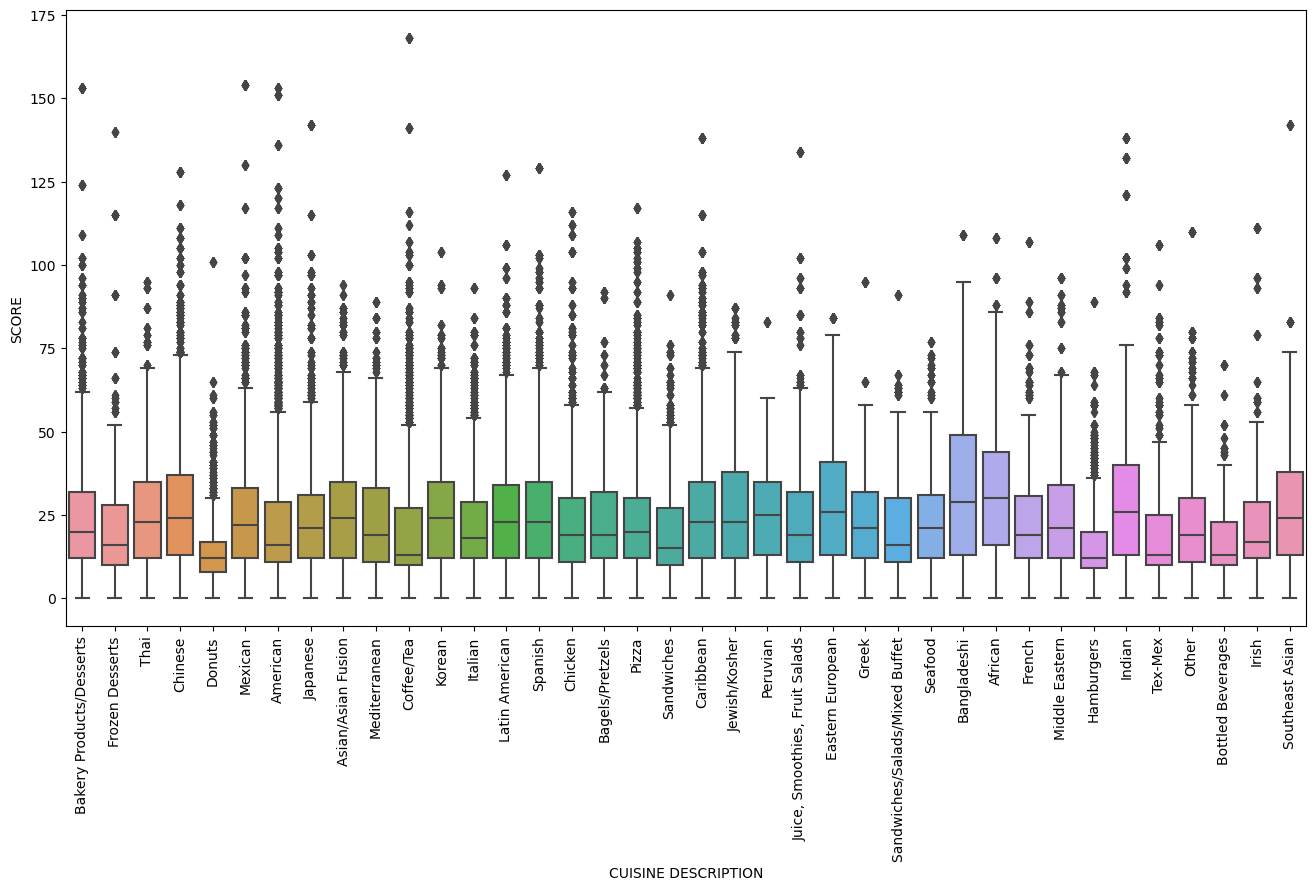

In [28]:
# Let us look at the scores by cuisine
score_cuisine = pd.concat([f_df['CUISINE DESCRIPTION'], f_df['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = fdf)
plt.xticks(rotation=90);

# **Action Analysis**

In [29]:
rd.ACTION.value_counts()

ACTION
Violations were cited in the following area(s).                                                                                       228131
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      8563
Establishment re-opened by DOHMH.                                                                                                       1925
No violations were recorded at the time of this inspection.                                                                             1370
Establishment re-closed by DOHMH.                                                                                                          6
Name: count, dtype: int64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Violations were cited in the following area(s).'),
  Text(1, 0, 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'),
  Text(2, 0, 'No violations were recorded at the time of this inspection.'),
  Text(3, 0, 'Establishment re-opened by DOHMH.'),
  Text(4, 0, 'Establishment re-closed by DOHMH.')])

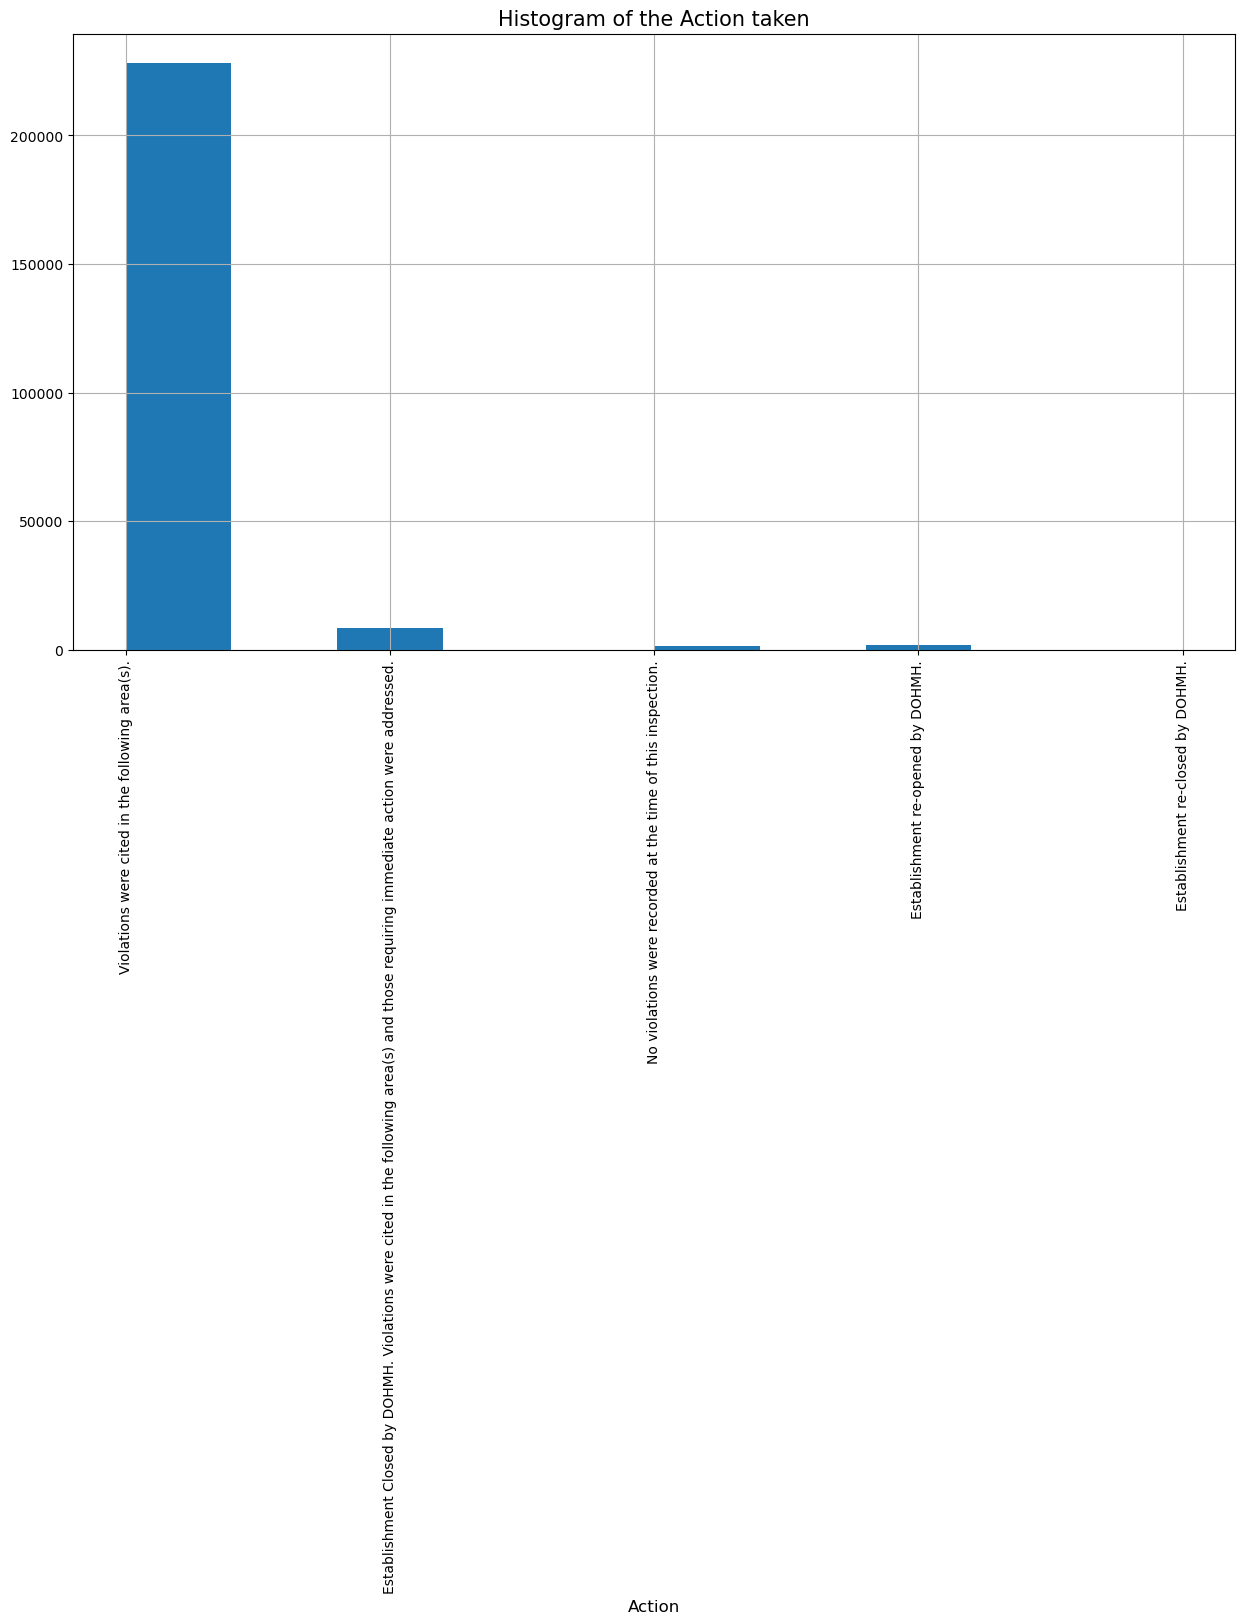

In [30]:
# Histogram of the Action taken
rd.ACTION.hist(figsize = (15,8))
plt.title('Histogram of the Action taken', fontsize = 15)
plt.xlabel('Action', fontsize = 12)
plt.xticks(rotation=90)

In [31]:
rd['CRITICAL FLAG'].value_counts()

CRITICAL FLAG
Critical          130880
Not Critical      106355
Not Applicable      5447
Name: count, dtype: int64

Text(0.5, 0, 'Flag')

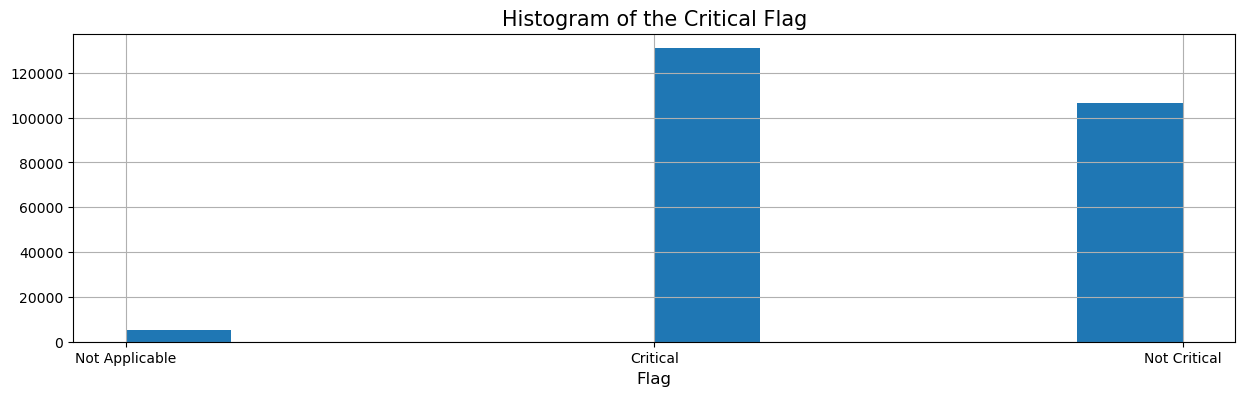

In [32]:
# Graphical representation of the critical flag
rd['CRITICAL FLAG'].hist(figsize=(15,4))
plt.title('Histogram of the Critical Flag', fontsize = 15)
plt.xlabel('Flag', fontsize = 12)

Text(0.5, 1.0, 'Critical Flag by Borough')

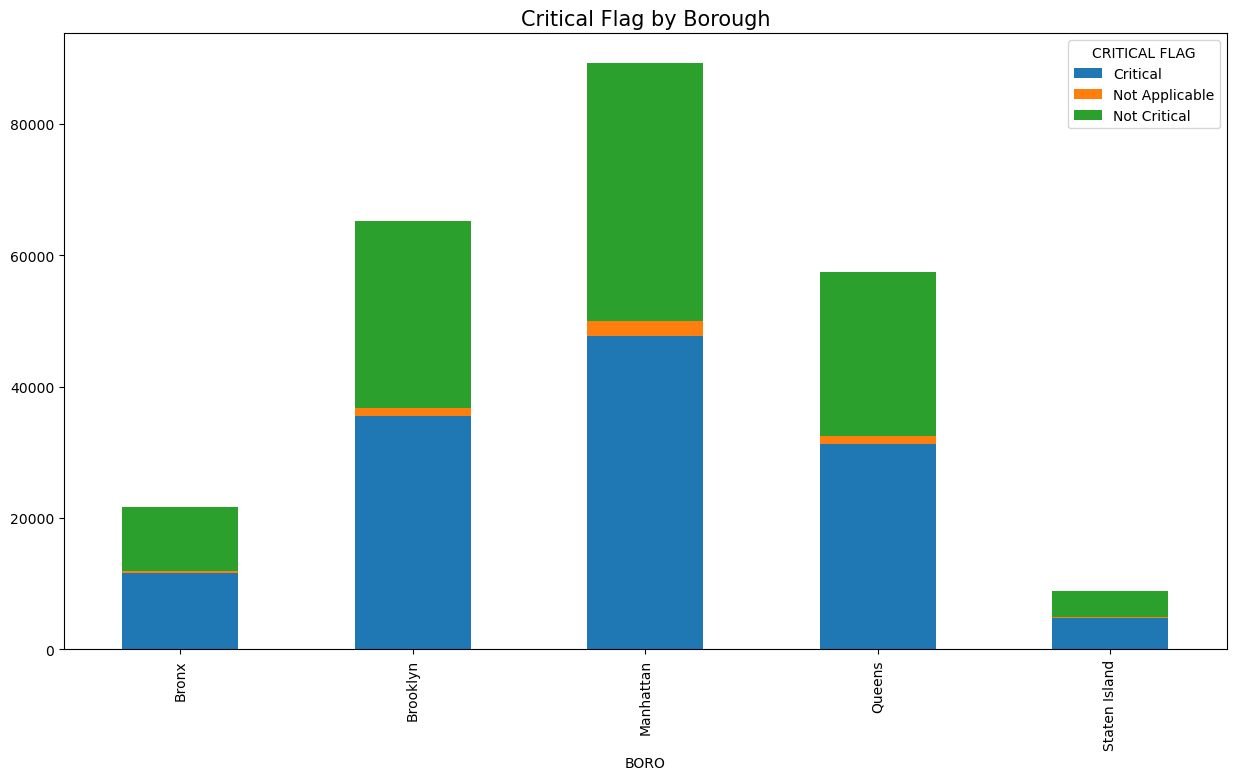

In [33]:
# Critical Flag by Borough
pd.crosstab(f_df.BORO, f_df['CRITICAL FLAG']).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Critical Flag by Borough', fontsize = 15)

Text(0.5, 1.0, 'Critical Flag by Cuisine')

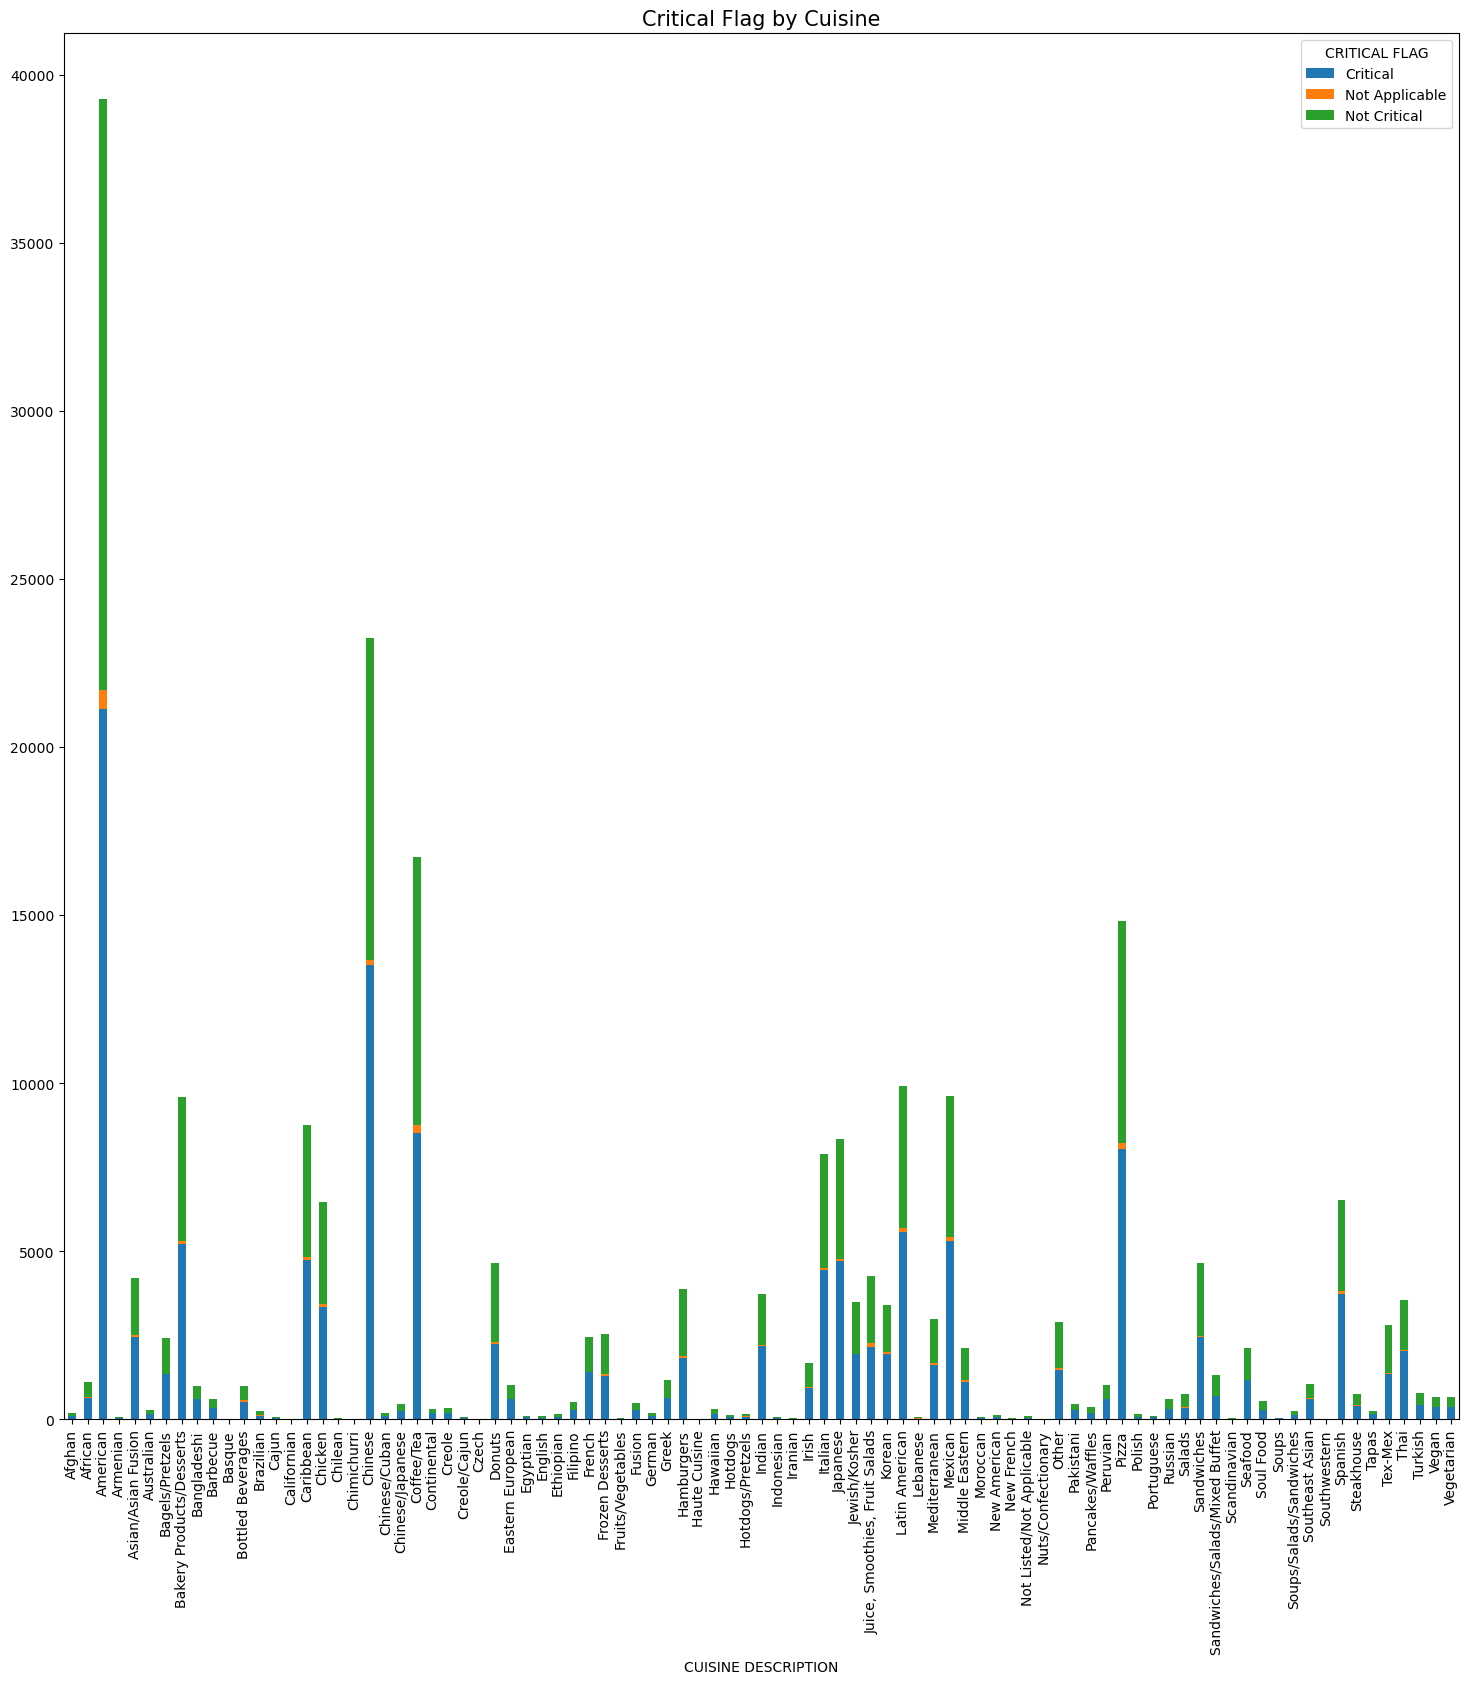

In [34]:
# Critical Flag by Cuisine
pd.crosstab(rd['CUISINE DESCRIPTION'], rd['CRITICAL FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15)

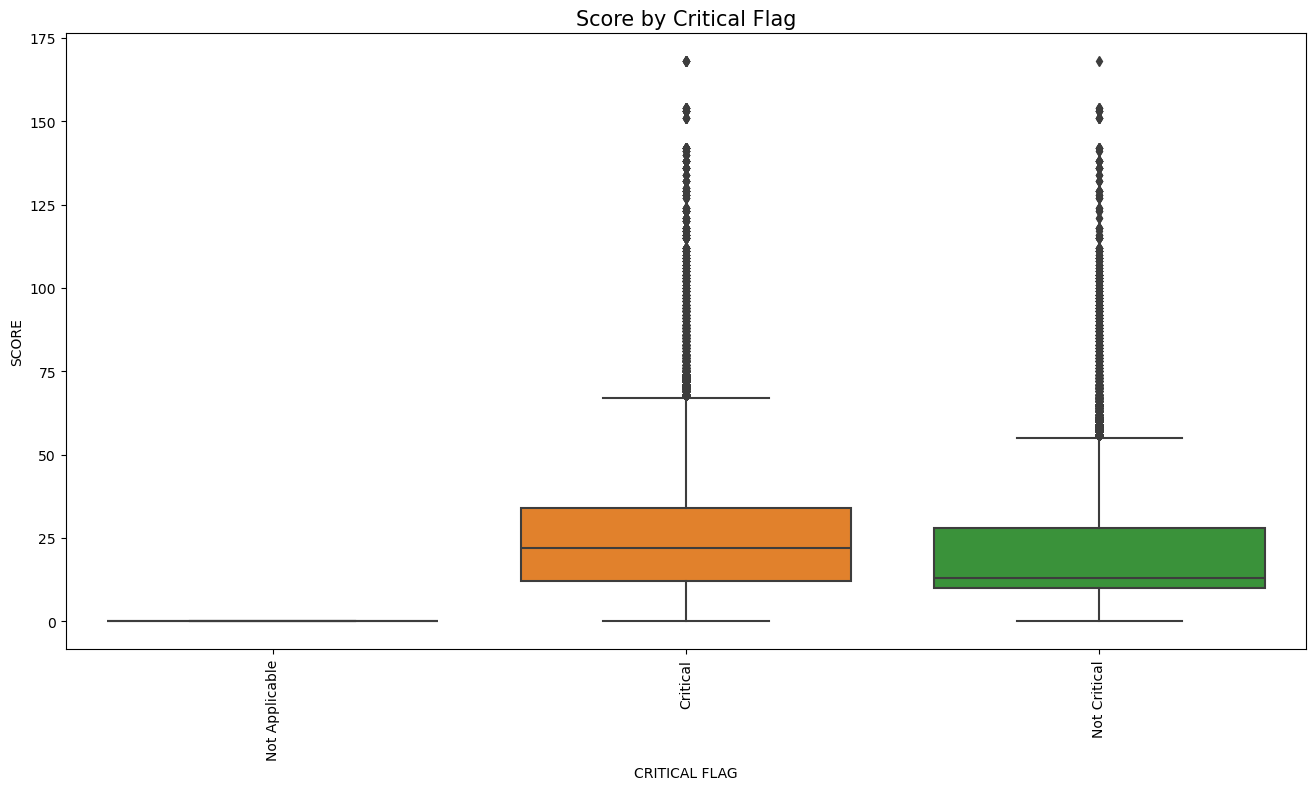

In [35]:
# Let us look at the scores by critical flag
score_flag = pd.concat([rd['CRITICAL FLAG'], rd['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CRITICAL FLAG', y="SCORE", data = score_flag)
plt.title('Score by Critical Flag', fontsize = 15)
plt.xticks(rotation=90);

In [36]:
f_df['VIOLATION DESCRIPTION'].value_counts()

VIOLATION DESCRIPTION
Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                      24544
Establishment is not free of harborage or conditions conducive to rodents, insects or other pests.                                                                                                                                           17468
Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.                                                                                               16125
Cold TCS food item held above 41 °F; smoked or processed fish held above 38 °F; intact raw eggs held above 45 °F; or reduced oxygen packaged (ROP) TCS foods held above required temperatures except during active necessary preparation.    11109
Anti-s

In [37]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()
    

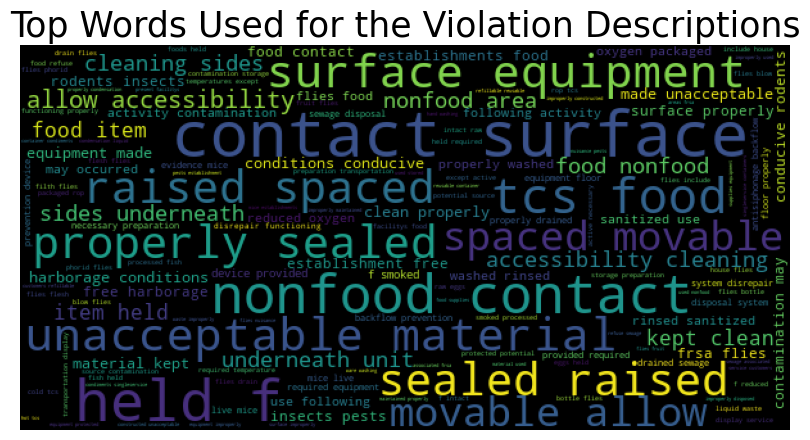

In [38]:
# Let us create a word cloud for the violation description
temp_data = rd.dropna(subset=['VIOLATION DESCRIPTION'])
# converting into lowercase
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].map(text_prepare)
# Wordcloud visual for most used words for Violation Desriptions
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['VIOLATION DESCRIPTION'].values))
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.title("Top Words Used for the Violation Descriptions", fontsize=25)
plt.axis("off")
plt.show()